# MIDI Transcription Evaluation with `mir_eval`

This notebook reproduces the workflow from the `112925_Testing.pdf` file:

* Note‑level transcription metrics
* Piano‑roll visualizations and overlays
* Onset alignment plot
* Framewise chroma cross‑similarity (SSM)
* Framewise multi‑pitch and melody metrics

In [3]:
import numpy as np
import pretty_midi
import mir_eval
from datetime import datetime
# Paths to MIDI files
# Ground‑truth MIDI from the DAW
ref_midi_path = "HuskyTest.mid"

# Audio‑to‑MIDI output to be evaluated
est_midi_path = "recording_1764465311_bp.mid"

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

In [4]:
def midi_to_intervals_pitches(midi_path):
    """
    Convert a MIDI file to (intervals, pitches) for mir_eval.transcription.

    Returns
    -------
    intervals : (N, 2) float ndarray
        [[onset, offset], ...] in seconds
    pitches : (N,) float ndarray
        MIDI pitch numbers
    """
    pm = pretty_midi.PrettyMIDI(midi_path)
    notes = [note for inst in pm.instruments for note in inst.notes]

    if not notes:
        raise ValueError(f"No notes found in MIDI file: {midi_path}")

    intervals = np.array([[n.start, n.end] for n in notes], dtype=float)
    pitches   = np.array([n.pitch for n in notes], dtype=float)  # mir_eval expects float

    return intervals, pitches


def align_by_first_note(ref_intervals, est_intervals, clip_to_zero=True):
    """
    Simple global time-shift alignment:
    shift est_intervals so that its first onset matches the reference's.

    Returns
    -------
    est_aligned : (N, 2) float ndarray
    offset      : float  (est - ref, seconds)
    """
    offset = est_intervals[0, 0] - ref_intervals[0, 0]
    est_aligned = est_intervals.copy()
    est_aligned -= offset

    if clip_to_zero:
        est_aligned[:, 0] = np.clip(est_aligned[:, 0], 0.0, None)
        est_aligned[:, 1] = np.clip(est_aligned[:, 1], 0.0, None)

    return est_aligned, offset


In [5]:
# Convert both MIDIs to intervals + pitches
ref_intervals, ref_pitches = midi_to_intervals_pitches(ref_midi_path)
est_intervals, est_pitches = midi_to_intervals_pitches(est_midi_path)

# Optional: global alignment so first notes line up
est_intervals_aligned, offset = align_by_first_note(ref_intervals, est_intervals)
print(f"Applied global offset (est - ref): {offset:.4f} s")

# Compute note-level metrics
precision, recall, f1, overlap = mir_eval.transcription.precision_recall_f1_overlap(
    ref_intervals, ref_pitches,
    est_intervals_aligned, est_pitches,
    onset_tolerance=0.05,   # 50 ms onset tolerance
    offset_ratio=None       # or e.g. 0.2 to enforce offset accuracy
)

print("\nNote-level transcription metrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1:        {f1:.4f}")
print(f"  Overlap:   {overlap:.4f}")


Applied global offset (est - ref): 0.3727 s

Note-level transcription metrics:
  Precision: 1.0000
  Recall:    1.0000
  F1:        1.0000
  Overlap:   0.8710


## Piano‑roll visualizations

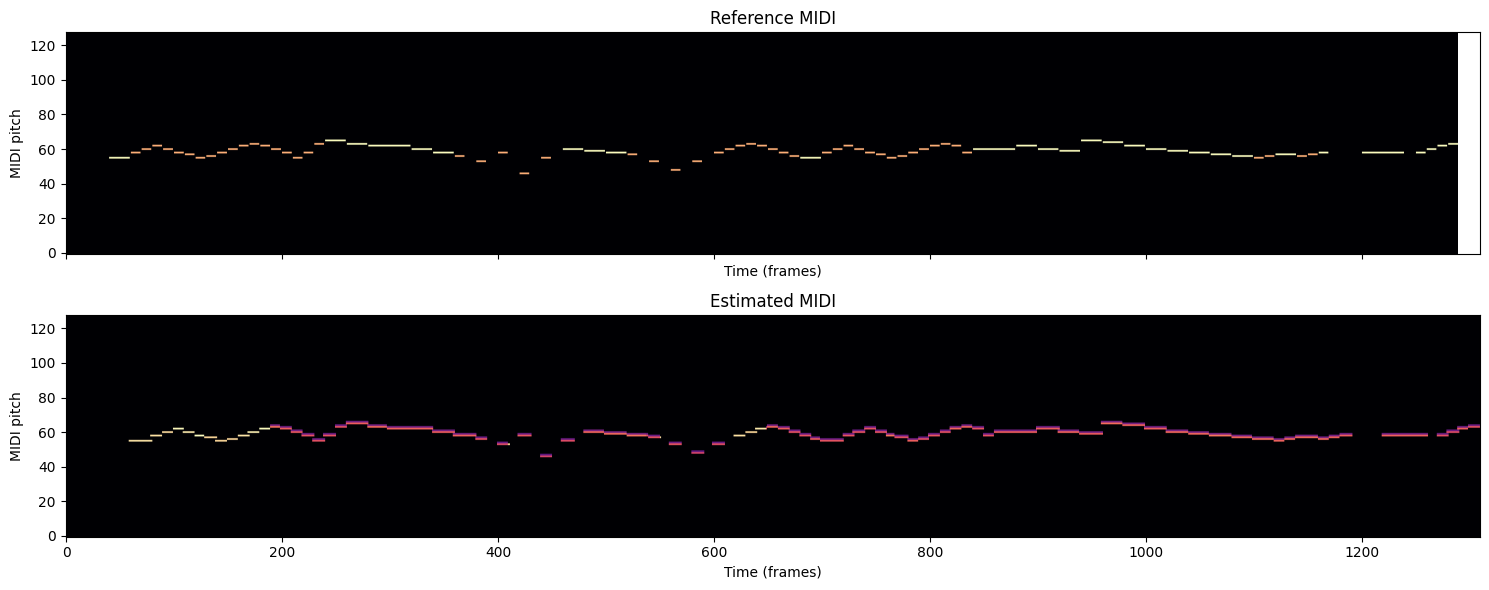

In [16]:
import matplotlib.pyplot as plt

def plot_pianoroll(pm, ax, title, fs=50):
    """Plot a piano‑roll for a PrettyMIDI object."""
    roll = pm.get_piano_roll(fs=fs)  # shape (128, T)
    ax.imshow(roll,
              origin="lower", cmap = "magma",
              aspect="auto")
    ax.set_title(title)
    ax.set_ylabel("MIDI pitch")
    ax.set_xlabel("Time (frames)")


ref_pm = pretty_midi.PrettyMIDI(ref_midi_path)
est_pm = pretty_midi.PrettyMIDI(est_midi_path)

fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
plot_pianoroll(ref_pm, axs[0], "Reference MIDI")
plot_pianoroll(est_pm, axs[1], "Estimated MIDI")
plt.tight_layout()
plt.savefig(f"Piano_Roll_{timestamp}_Test.jpg", dpi=200, bbox_inches="tight")
plt.show()

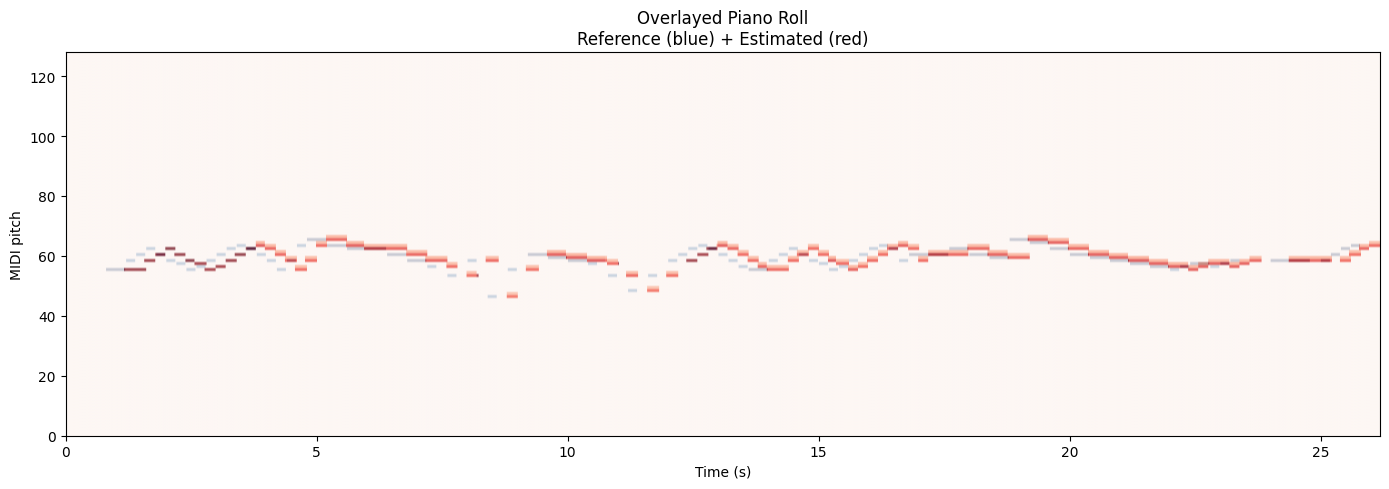

In [17]:
# Overlayed piano‑rolls (no offset correction)

fs = 50  # frames per second for piano‑roll
ref_roll = ref_pm.get_piano_roll(fs=fs)  # (128, T_ref)
est_roll = est_pm.get_piano_roll(fs=fs)  # (128, T_est)

# Pad to same length
T = max(ref_roll.shape[1], est_roll.shape[1])
if ref_roll.shape[1] < T:
    ref_roll = np.pad(ref_roll, ((0, 0), (0, T - ref_roll.shape[1])))
if est_roll.shape[1] < T:
    est_roll = np.pad(est_roll, ((0, 0), (0, T - est_roll.shape[1])))

time_axis = np.arange(T) / fs

fig, ax = plt.subplots(figsize=(14, 5))
fig.patch.set_facecolor("white")   # whole figure
ax.set_facecolor("white")          # axes area
ax.imshow(ref_roll, origin="lower", aspect="auto", cmap= "Blues",
          extent=[time_axis[0], time_axis[-1], 0, 128], alpha=0.7)
ax.imshow(est_roll, origin="lower", aspect="auto", cmap = "Reds",
          extent=[time_axis[0], time_axis[-1], 0, 128], alpha=0.7)
ax.set_ylim(0, 128)
ax.set_xlabel("Time (s)")
ax.set_ylabel("MIDI pitch")
ax.set_title("Overlayed Piano Roll\nReference (blue) + Estimated (red)")

plt.tight_layout()

plt.savefig(f"pianoroll_{timestamp}_overlay.png", dpi=300, bbox_inches="tight")
plt.show()

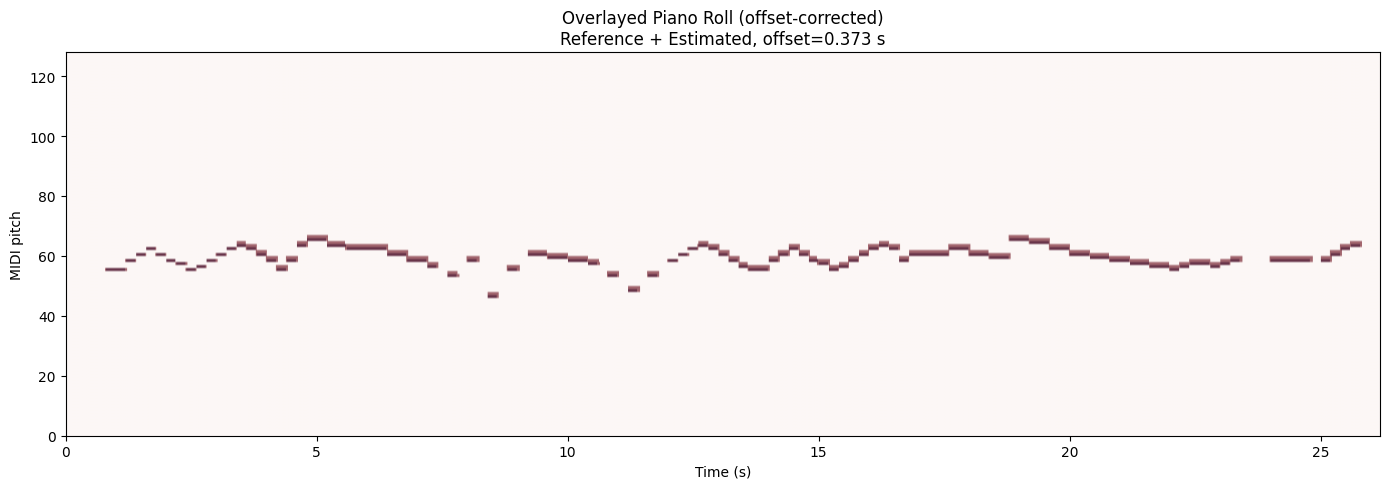

Offset (s): 0.3727272727272726
ref_roll shape: (128, 1310) nonzeros: 1038
est_roll shape: (128, 1310) nonzeros: 2211


In [19]:
# Overlayed piano‑rolls with offset correction applied to estimated roll

from matplotlib import colors as mcolors

# offset_s = est_start - ref_start  (seconds)
shift_frames = int(round(offset_s * fs))

T = ref_roll.shape[1]  # or est_roll.shape[1], they should be equal

if shift_frames > 0:
    # Estimated starts LATER -> shift it EARLIER (left)
    est_roll_shifted = np.zeros_like(est_roll)
    est_roll_shifted[:, :T-shift_frames] = est_roll[:, shift_frames:T]

elif shift_frames < 0:
    # Estimated starts EARLIER -> shift it LATER (right)
    s = abs(shift_frames)
    est_roll_shifted = np.zeros_like(est_roll)
    est_roll_shifted[:, s:T] = est_roll[:, :T-s]

else:
    est_roll_shifted = est_roll.copy()

fig, ax = plt.subplots(figsize=(14, 5))

# Normalize separately so both images are visible
ref_bin = (ref_roll > 0).astype(float)
est_bin = (est_roll_shifted > 0).astype(float)

ax.imshow(ref_bin, origin="lower", aspect="auto", cmap = "Blues",
          extent=[time_axis[0], time_axis[-1], 0, 128],
          alpha=0.6)
ax.imshow(est_bin, origin="lower", aspect="auto", cmap = "Reds",
          extent=[time_axis[0], time_axis[-1], 0, 128],
          alpha=0.6)
ax.set_ylim(0, 128)
ax.set_xlabel("Time (s)")
ax.set_ylabel("MIDI pitch")
ax.set_title(f"Overlayed Piano Roll (offset‑corrected)\n"
             f"Reference + Estimated, offset={offset_s:0.3f} s")

plt.tight_layout()
plt.savefig(f"pianoroll_{timestamp}_overlay_offset_corrected.png",
            dpi=300, bbox_inches="tight")
plt.show()

print("Offset (s):", offset_s)
print("ref_roll shape:", ref_roll.shape, "nonzeros:", np.count_nonzero(ref_roll))
print("est_roll shape:", est_roll.shape, "nonzeros:", np.count_nonzero(est_roll))

## Onset alignment plot

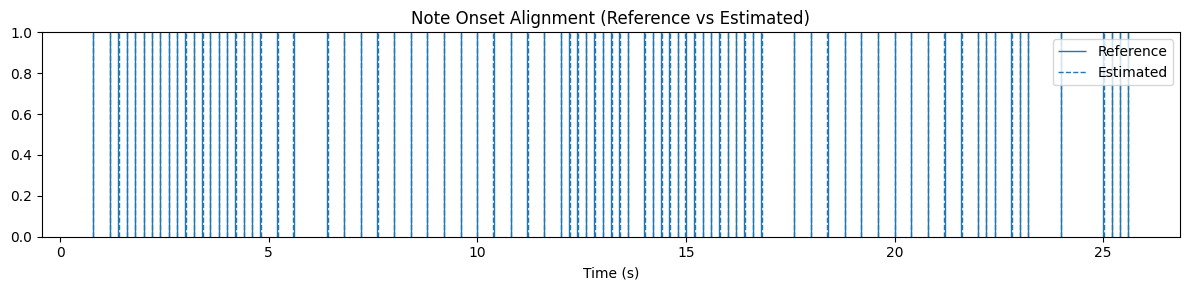

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Re‑use ref_intervals / est_intervals_aligned from above
ref_onsets = ref_intervals[:, 0]
est_onsets = est_intervals_aligned[:, 0]

plt.figure(figsize=(12, 3))
plt.vlines(ref_onsets, 0, 1, label="Reference", linewidth=1)
plt.vlines(est_onsets, 0, 1, label="Estimated", linewidth=1, linestyles="dashed")
plt.ylim(0, 1)
plt.xlabel("Time (s)")
plt.title("Note Onset Alignment (Reference vs Estimated)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"OnsetAlignment_{timestamp}_Test.jpg", dpi=200, bbox_inches="tight")
plt.show()

## Framewise chroma SSM and metrics

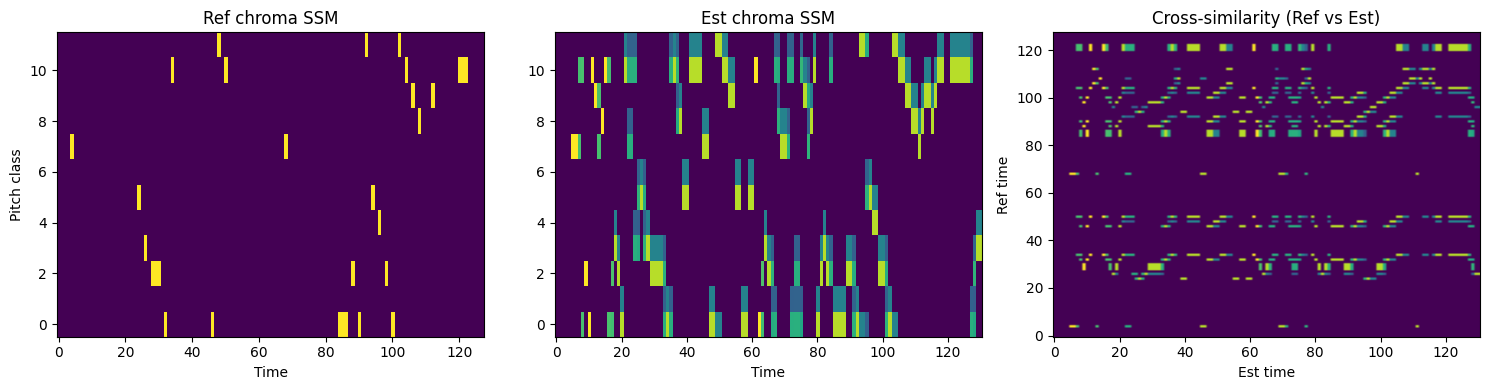

In [22]:
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt

def midi_to_chroma(pm, fs=5):
    """Return chroma (12 x T) from a PrettyMIDI object."""
    chroma = pm.get_chroma(fs=fs)  # 12 x T
    # Normalize per‑frame to unit length to make cosine similarity meaningful
    chroma_norm = np.linalg.norm(chroma, axis=0, keepdims=True) + 1e-9
    chroma = chroma / chroma_norm
    return chroma


def cross_similarity(chroma1, chroma2):
    """Cosine similarity matrix between two chroma sequences.
    
    chroma1 : 12 x T1
    chroma2 : 12 x T2
    Returns S : T1 x T2 similarity matrix.
    """
    X1 = chroma1.T   # T1 x 12
    X2 = chroma2.T   # T2 x 12
    S = np.dot(X1, X2.T)  # T1 x T2
    return S


# Load MIDIs
ref_pm = pretty_midi.PrettyMIDI(ref_midi_path)
est_pm = pretty_midi.PrettyMIDI(est_midi_path)

# Chroma sequences
fs_chroma = 5  # frames per second for chroma
ref_chroma = midi_to_chroma(ref_pm, fs=fs_chroma)
est_chroma = midi_to_chroma(est_pm, fs=fs_chroma)

# Cross‑similarity
SSM = cross_similarity(ref_chroma, est_chroma)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(ref_chroma, origin="lower", aspect="auto")
axes[0].set_title("Ref chroma SSM")
axes[0].set_ylabel("Pitch class")
axes[0].set_xlabel("Time")

axes[1].imshow(est_chroma, origin="lower", aspect="auto")
axes[1].set_title("Est chroma SSM")
axes[1].set_xlabel("Time")

axes[2].imshow(SSM, origin="lower", aspect="auto")
axes[2].set_title("Cross‑similarity (Ref vs Est)")
axes[2].set_xlabel("Est time")
axes[2].set_ylabel("Ref time")

plt.tight_layout()
plt.savefig(f"SSM_{timestamp}.png", dpi=300, bbox_inches="tight")
plt.show()

### Framewise multi‑pitch metrics with `mir_eval.multipitch`

In [23]:
def midi_to_framewise_freqs(pm, fs=100, time_shift=0.0):
    """Convert PrettyMIDI object to framewise frequencies for mir_eval.multipitch.

    Parameters
    ----------
    pm : pretty_midi.PrettyMIDI
    fs : float
        Frames per second.
    time_shift : float
        Value *subtracted* from note times (seconds).  Use the same
        offset you used to align note intervals.
    
    Returns
    -------
    times : ndarray, shape (T,)
        Time stamps for each frame.
    freqs : list of ndarray
        Each element is an array of active frequencies (Hz) at that frame.
    """
    end_time = pm.get_end_time()
    times = np.arange(0, end_time, 1.0 / fs)
    T = len(times)
    
    freqs = [[] for _ in range(T)]
    
    for inst in pm.instruments:
        if inst.is_drum:
            continue
        for note in inst.notes:
            onset = note.start - time_shift
            offset = note.end - time_shift
            onset_idx = int(np.floor(onset * fs))
            offset_idx = int(np.ceil(offset * fs))
            onset_idx = max(onset_idx, 0)
            offset_idx = min(offset_idx, T)
            hz = pretty_midi.note_number_to_hz(note.pitch)
            for t in range(onset_idx, offset_idx):
                freqs[t].append(hz)
    
    # Convert lists to numpy arrays
    freqs = [np.array(f, dtype=float) for f in freqs]
    return times, freqs


# Framewise freqs for reference and estimate
ref_pm = pretty_midi.PrettyMIDI(ref_midi_path)
est_pm = pretty_midi.PrettyMIDI(est_midi_path)

fs_mp = 100
ref_times, ref_freqs = midi_to_framewise_freqs(ref_pm, fs=fs_mp,
                                               time_shift=0.0)
est_times, est_freqs = midi_to_framewise_freqs(est_pm, fs=fs_mp,
                                               time_shift=offset)

mp_scores = mir_eval.multipitch.evaluate(
    ref_times, ref_freqs,
    est_times, est_freqs
)

for k, v in mp_scores.items():
    print(f"{k:>20s}: {v:0.4f}")

           Precision: 0.8985
              Recall: 0.9839
            Accuracy: 0.8855
  Substitution Error: 0.0152
          Miss Error: 0.0009
   False Alarm Error: 0.0960
         Total Error: 0.1121
    Chroma Precision: 0.8985
       Chroma Recall: 0.9839
     Chroma Accuracy: 0.8855
Chroma Substitution Error: 0.0152
   Chroma Miss Error: 0.0009
Chroma False Alarm Error: 0.0960
  Chroma Total Error: 0.1121


C:\Users\evand\OneDrive\Desktop\CSE5312\Final Project\.venv\Lib\site-packages\mir_eval\multipitch.py:413: UserWarning: Estimate times not equal to reference times. Resampling to common time base.
  warnings.warn(


## MIR\_EVAL Melody metrics

In [24]:
def top_melody_from_midi(pm, fs=100, time_shift=0.0):
    """Return (times, f0, voicing) suitable for mir_eval.melody.evaluate.

    Chooses the highest active pitch at each frame as the melody.
    """
    times, freqs = midi_to_framewise_freqs(pm, fs=fs, time_shift=time_shift)
    T = len(times)
    f0 = np.zeros(T, dtype=float)
    voicing = np.zeros(T, dtype=bool)
    
    for t in range(T):
        if len(freqs[t]) > 0:
            f0[t] = np.max(freqs[t])
            voicing[t] = True
    
    return times, f0, voicing


# Build reference and estimate sequences
ref_pm = pretty_midi.PrettyMIDI(ref_midi_path)
est_pm = pretty_midi.PrettyMIDI(est_midi_path)

mel_fs = 100
ref_t, ref_f0, ref_voiced = top_melody_from_midi(ref_pm, fs=mel_fs,
                                                 time_shift=0.0)
est_t, est_f0, est_voiced = top_melody_from_midi(est_pm, fs=mel_fs,
                                                 time_shift=offset)

print("ref shapes:", ref_t.shape, ref_f0.shape, ref_voiced.shape)
print("est shapes:", est_t.shape, est_f0.shape, est_voiced.shape)

melody_scores = mir_eval.melody.evaluate(
    ref_t, ref_f0, ref_voiced,
    est_t, est_f0, est_voiced
)

for k, v in melody_scores.items():
    print(f"{k:>25s}: {v:0.4f}")

ref shapes: (2580,) (2580,) (2580,)
est shapes: (2621,) (2621,) (2621,)


IndexError: boolean index did not match indexed array along axis 0; size of axis is 2621 but size of corresponding boolean axis is 2580